# Introduction

In this lab, we will learn how to use calibration curves to evaluate the predicted probabilities of a classification model. We will use scikit-learn to perform the classification and visualize the results.

# Dataset

We will use a synthetic binary classification dataset with 100,000 samples and 20 features. Of the 20 features, only 2 are informative, 10 are redundant (random combinations of the informative features) and the remaining 8 are uninformative (random numbers). Of the 100,000 samples, 1,000 will be used for model fitting and the rest for testing.

In [1]:
from matplotlib.pyplot import xlabel
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000,
    n_features=20,
    n_informative=2,
    n_redundant=10,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=42)

# Calibration Curves

We will compare several classifiers with calibration curves. First, we will compare:

- Logistic Regression (used as a baseline)
- Uncalibrated Gaussian Naive Bayes
- Gaussian Naive Bayes with isotonic and sigmoid calibration

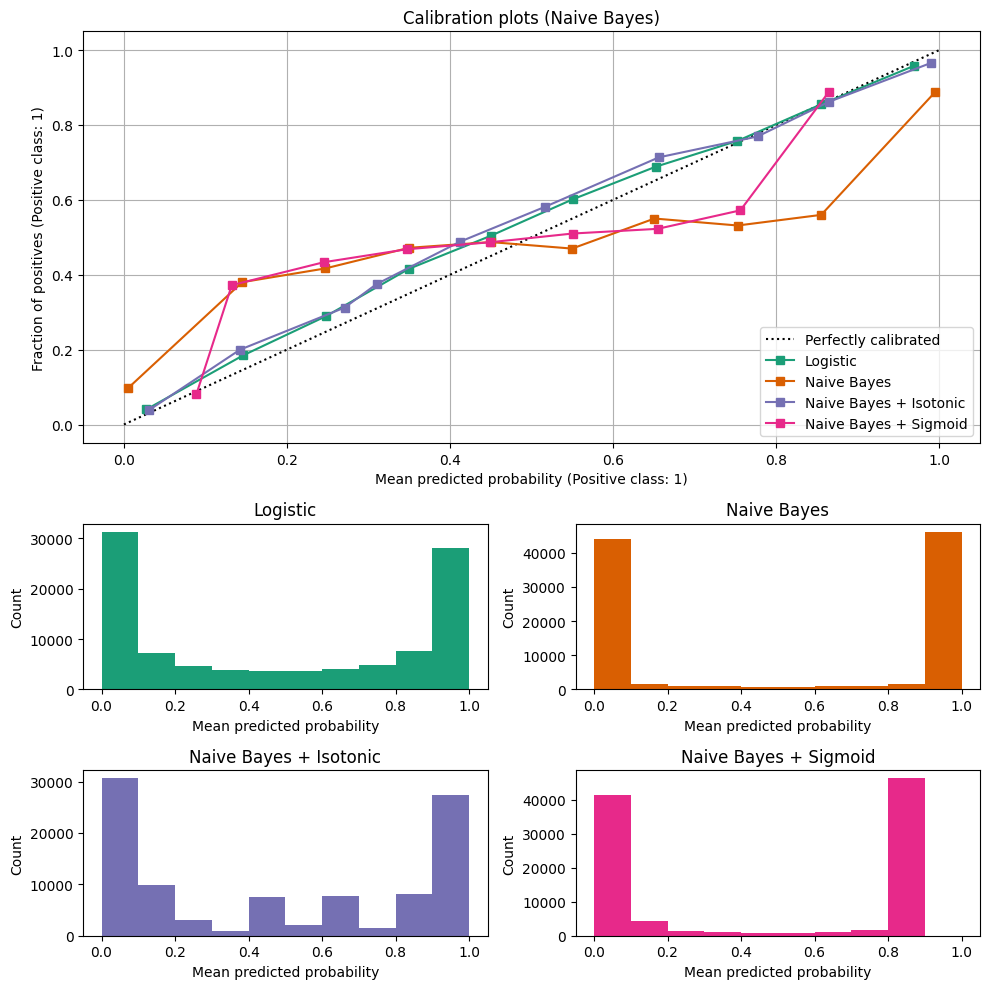

In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr = LogisticRegression(C=1.0)
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
    (gnb_sigmoid, "Naive Bayes + Sigmoid"),
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

# Linear Support Vector Classifier

Next, we will compare:

- Logistic Regression (baseline)
- Uncalibrated Linear Support Vector Classifier (SVC)
- Linear SVC with isotonic and sigmoid calibration

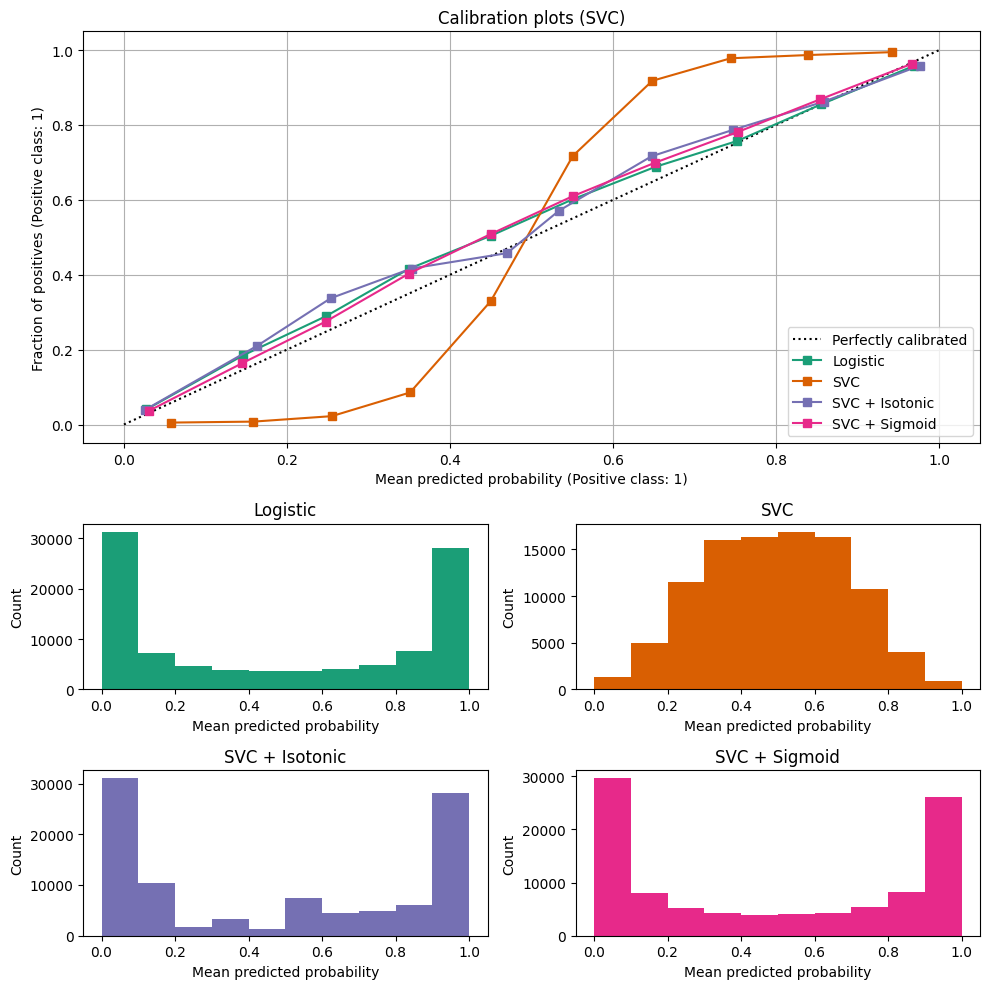

In [6]:
import numpy as np

from sklearn.svm import LinearSVC


class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output for binary classification."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0, 1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

lr = LogisticRegression(C=1.0)
svc = NaivelyCalibratedLinearSVC(max_iter=10_000, dual="auto")
svc_isotonic = CalibratedClassifierCV(svc, cv=2, method="isotonic")
svc_sigmoid = CalibratedClassifierCV(svc, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (svc, "SVC"),
    (svc_isotonic, "SVC + Isotonic"),
    (svc_sigmoid, "SVC + Sigmoid"),
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (SVC)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

# Evaluation

We will evaluate the classifiers with several classification metrics: brier_score_loss, log_loss, precision, recall, F1 score, and ROC AUC.

In [8]:
from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    brier_score_loss,
    log_loss,
    roc_auc_score,
)

scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores['Classifier'].append(name)

    for metric in[brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace('score', '').capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace('score', '').capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

In [9]:
score_df

,Brier loss,Log loss,Roc auc,Precision,Recall,F1
Classifier,,,,,,
Logistic,0.098932,0.323200,0.937443,0.871965,0.851348,0.861533
SVC,0.144943,0.465660,0.937597,0.872186,0.851792,0.861868
SVC + Isotonic,0.099820,0.376999,0.936480,0.853174,0.877981,0.865400
SVC + Sigmoid,0.098758,0.321301,0.937532,0.873724,0.848743,0.861053


# Summary

We learned how to use calibration curves to evaluate the predicted probabilities of a classification model. We compared several classifiers with calibration curves and evaluated them with several classification metrics. We also learned that parametric sigmoid calibration can deal with situations where the calibration curve of the base classifier is sigmoid, but not where it is transposed-sigmoid. Non-parametric isotonic calibration can deal with both situations but may require more data to produce good results.